In [1]:
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from time import time

Using TensorFlow backend.


In [10]:
import cv2

from scipy.misc import imresize
from skimage.transform import resize

import glob

import matplotlib.pyplot as plt
%matplotlib inline

from keras.callbacks import EarlyStopping

In [11]:
# define abmap
abmap = np.zeros((9,9))
m = 0
i = 0
j = 0
p = 0
for n in range(81):
    abmap[i,j]=n
    if p==0:
        if i==8:
            p=1
            j+=1
            m=1
        elif m==0:#go down
            if j==0:
                i+=1
                m=1 
            else:
                i+=1
                j-=1
        else:#go up
            if i==0:
                j+=1
                m=0
            else:
                i-=1
                j+=1  
    else:
        if m==0:#go down
            if i==8:
                j+=1
                m=1 
            else:
                i+=1
                j-=1
        else:#go up
            if j==8:
                i+=1
                m=0
            else:
                i-=1
                j+=1  
abmap

array([[  0.,   2.,   3.,   9.,  10.,  20.,  21.,  35.,  36.],
       [  1.,   4.,   8.,  11.,  19.,  22.,  34.,  37.,  52.],
       [  5.,   7.,  12.,  18.,  23.,  33.,  38.,  51.,  53.],
       [  6.,  13.,  17.,  24.,  32.,  39.,  50.,  54.,  65.],
       [ 14.,  16.,  25.,  31.,  40.,  49.,  55.,  64.,  66.],
       [ 15.,  26.,  30.,  41.,  48.,  56.,  63.,  67.,  74.],
       [ 27.,  29.,  42.,  47.,  57.,  62.,  68.,  73.,  75.],
       [ 28.,  43.,  46.,  58.,  61.,  69.,  72.,  76.,  79.],
       [ 44.,  45.,  59.,  60.,  70.,  71.,  77.,  78.,  80.]])

In [4]:
def Q81z(a,b):
    h,w = a.shape
    y = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            mapi = int(np.floor(a[i,j]/29))
            mapj = int(np.floor(b[i,j]/29))
            y[i,j] = abmap[mapi,mapj]        
    return y

In [31]:
def deQ81z(x,y):
    h,w = y.shape
    a = np.zeros((h,w))
    b = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            yi = y[i,j]
            if yi<80.5:
                ai,bi = np.where(round(y[i,j])==abmap) 
                a[i,j] = (ai*29+14)[0]
                b[i,j] = (bi*29+14)[0]
            else:
                a[i,j] = 255
                b[i,j] = 255
    img_lab = np.zeros((h,w,3))
    img_lab[:,:,0] = x
    img_lab[:,:,1] = a
    img_lab[:,:,2] = b
    img = cv2.cvtColor(img_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)
    return img

In [6]:
# read images and split a b
img_all = []
X = []
Y = []
for img in glob.glob(r"../../images/*.jpg"):
    n= cv2.imread(img)#BGR
    if not n is None and np.mean(n)<250 and np.mean(np.std(n,axis=2))>2:
    # drop None pic, almost white pic, almost gray scale pic
        m = imresize(n,(400,400,3))
        img_lab = cv2.cvtColor(m.astype(np.uint8), cv2.COLOR_BGR2LAB)
        L = img_lab[:,:,0]
        a = img_lab[:,:,1]
        b = img_lab[:,:,2]
        img_all.append(m)
        y = Q81z(a,b)
        L = L.reshape(1, 400, 400, 1)
        y = y.reshape(1, 400, 400, 1) 
        Y.append(y)
        X.append(L)

In [9]:
X=np.array(X)
Y=np.array(Y)

num = 20
X=np.reshape(X, (num, 400, 400, 1))
Y=np.reshape(Y, (num, 400, 400, 1))

In [8]:
# Building the neural network 九层神经网络 跑一次就行了
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='relu', padding='same'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    9248      
__________

In [9]:
# Finish model
model.compile(optimizer='adam',loss='mse')

In [10]:
# 
t0 = time()
hist = model.fit(x=X, 
    y=Y,
    batch_size=4,
    epochs=10, callbacks=[EarlyStopping(patience=5)])
print('Train time: %.fs'%(time()-t0))

Epoch 1/10
20/20 [==============================] - 35s 2s/step - loss: 973.3567


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:526: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/10
20/20 [==============================] - 31s 2s/step - loss: 456.7154
Epoch 3/10
20/20 [==============================] - 27s 1s/step - loss: 387.3310
Epoch 4/10
20/20 [==============================] - 31s 2s/step - loss: 259.4056
Epoch 5/10
20/20 [==============================] - 27s 1s/step - loss: 231.4931
Epoch 6/10
20/20 [==============================] - 27s 1s/step - loss: 215.0182
Epoch 7/10
20/20 [==============================] - 36s 2s/step - loss: 218.6207
Epoch 8/10
20/20 [==============================] - 33s 2s/step - loss: 199.7230
Epoch 9/10
20/20 [==============================] - 29s 1s/step - loss: 198.7198
Epoch 10/10
20/20 [==============================] - 33s 2s/step - loss: 198.6692
Train time: 313s


In [11]:
model_json = model.to_json()
with open("model_Q81z_1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_Q81z_1.h5")

In [7]:
from keras.models import model_from_json

In [8]:
json_file = open('model_Q81z_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_Q81z_1.h5")

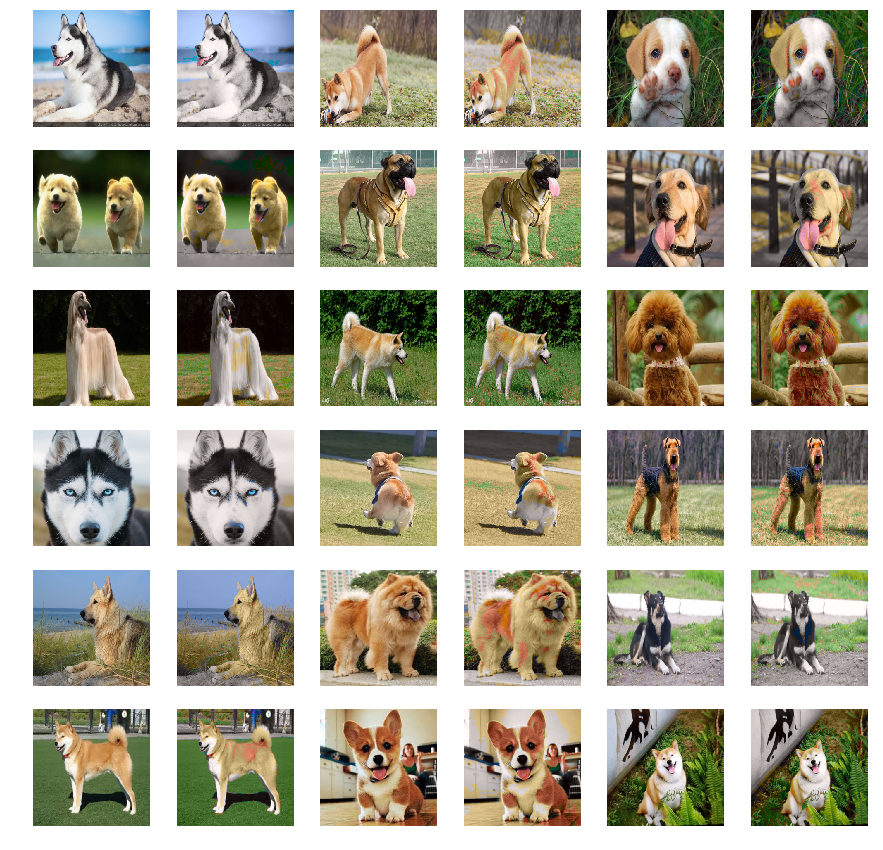

In [12]:
# reconstuction
j =1
plt.figure(figsize=(15,15))
for i in range(18):
    plt.subplot(6,6,j)
    j += 1
    plt.imshow(cv2.cvtColor(img_all[i],cv2.COLOR_BGR2RGB))
    plt.axis('OFF')
    plt.subplot(6,6,j)
    j += 1
    img_re = deQ81z(X[i,:,:,0],Y[i,:,:,0])
    plt.imshow(img_re)
    plt.axis('OFF')

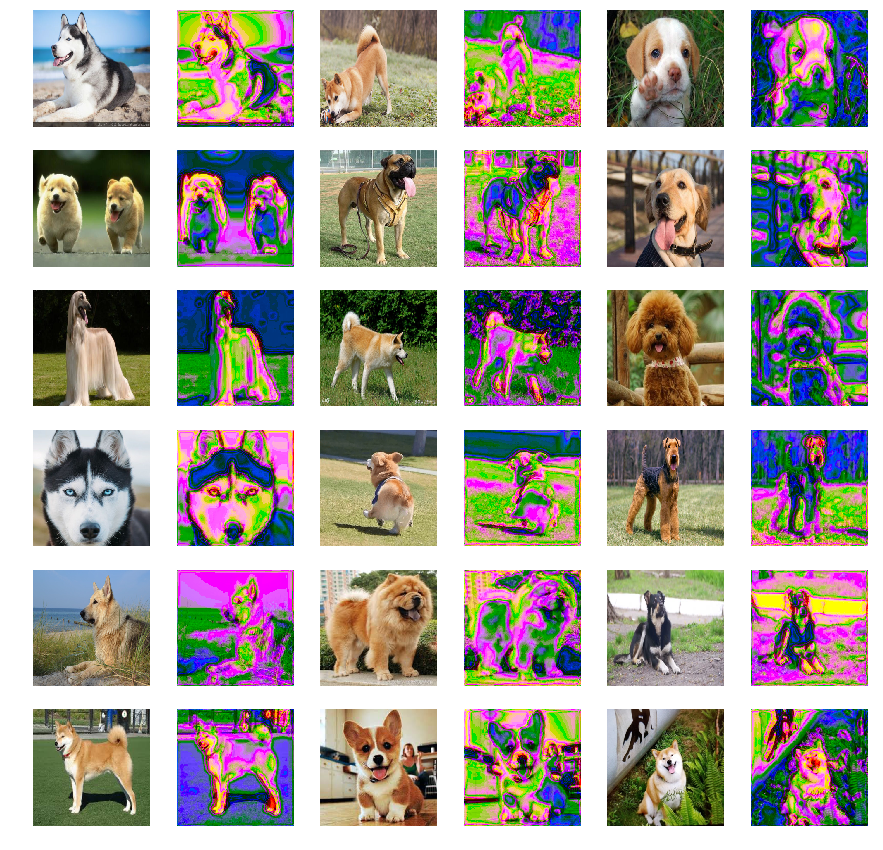

In [33]:
# predict train image
j =1
plt.figure(figsize=(15,15))
# Yhat = model.predict(X)
for i in range(18):
    plt.subplot(6,6,j)
    j += 1
    plt.imshow(cv2.cvtColor(img_all[i],cv2.COLOR_BGR2RGB))
    plt.axis('OFF')
    plt.subplot(6,6,j)
    j += 1
    Yhat = loaded_model.predict(X[i:i+1])
    imgtr_re = deQ81z(X[i,:,:,0],Yhat[0,:,:,0])
    plt.imshow(imgtr_re)
    plt.axis('OFF')

In [34]:
# read test image
imgts_all = []
Xts = []
Yts = []
for img in glob.glob(r"../../images/test/*.jpg"):
    n= cv2.imread(img)#BGR
    if not n is None and np.mean(n)<250 and np.mean(np.std(n,axis=2))>2:
    # drop None pic, almost white pic, almost gray scale pic
        m = imresize(n,(400,400,3))
        img_lab = cv2.cvtColor(m.astype(np.uint8), cv2.COLOR_BGR2LAB)
        L = img_lab[:,:,0]
        a = img_lab[:,:,1]
        b = img_lab[:,:,2]
        imgts_all.append(m)
        y = Q81z(a,b)
        L = L.reshape(1, 400, 400, 1)
        y = y.reshape(1, 400, 400, 1) 
        Yts.append(y)
        Xts.append(L)
Xts=np.array(Xts)
Yts=np.array(Yts)

num = 3
Xts=np.reshape(Xts, (num, 400, 400, 1))
Yts=np.reshape(Yts, (num, 400, 400, 1))

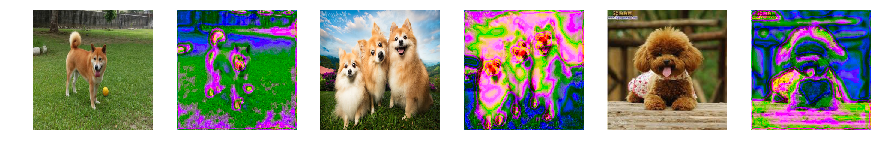

In [37]:
# predict new image
j =1
plt.figure(figsize=(15,5))

for i in range(3):
    plt.subplot(1,6,j)
    j += 1
    plt.imshow(cv2.cvtColor(imgts_all[i],cv2.COLOR_BGR2RGB))
    plt.axis('OFF')
    plt.subplot(1,6,j)
    j += 1
    Ytshat = loaded_model.predict(Xts[i:i+1])
    imgts_re = deQ81z(Xts[i,:,:,0],Ytshat[0,:,:,0])
    plt.imshow(imgts_re)
    plt.axis('OFF')